In [1]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import murdo
import transformers

%load_ext autoreload
%autoreload 2

# Integrating Epinet Into Armo Regression
> C'mon, c'mon and meet the epinets

ArmoRM's regression layer is pretty simple: it's just a linear layer, with a bias term, optimized through Ridge regression. In other words, it's just performing a change of basis on the underlying last-layer embeddings of Llama3 8b. And apparently, dimensions already exist in this marvelous latent space that correspond to many of the dimensions we care about.

What can the epinet add to this? First, the structure fo the epinet should be pretty simple: we'll replicate the linear layer being used with Ridge Regression an MLP (hoping gradient descent is sufficient to extract the same dimensional information; and assuming we need extra compute power to both get the dimensions and reason about their epistemic status), but will multiply the output by the random epistemic index. In theory, this should allow the epinet to reduce the MSE regression loss by adding randomness to dimensions with questionable epistemic status.

In this notebook, we integrate an mlp epinet with the regression layer. We'll try the simplest possible integration first, then perform training (which, given the small size, should be pretty quick), and iterate.

How will we measure whether the integration works? First, we can sanity check by seeing how uncertainty compares across dimensions of rewards, comparing with our prior data on which dimensions have the most activation and which appear to be duplicates of each other. Ultimately, we can measure the performance of the reward model by doing some uncertainty-weighted best of N search.

A note on form: prior versions of zetteldev had an emphasis on atomic notebooks for experimentation. We break from that. This document is more 'computational essay/lab report' than slip. It will contain many ideas, and confront much computational and ideological reducibility. The metaphors worthy of further abstraction will be highlighted in a separate report, so see the 'Reports' folder for the high level summary. What follows is a 'lab report' in chronological order.

**Hypothesis**:
1. Integrating the MLP reward model with an MLP epinet will enable the prediction of uncertainty per reward dimension per prompt.
2. The uncertainty estimate should change with prompt response pairs.
3. When the gating layer denotes a reward dimension as irrelevant, it should have a higher uncertainty.
4. Integrating uncertainty into a Best of N sampler from a base llama model should have superior performance to the reward model without uncertainty.

# Machinery

First, we'll set up the pretrained reward model, then extract dimensions and such from it.

In [2]:
import torch, numpy

In [3]:
model_name, dataset_name = ("FsfairX-LLaMA3-RM-v0.1", "ArmoRM-Multi-Objective-Data-v0.1")
save_dir = os.path.join("/home/piriac", "data", "ArmoRM", "regression_weights")
save_path = os.path.join(save_dir, f"{model_name}_{dataset_name}.pt")
regression_layer = torch.load(save_path)["weight"]

In [4]:
n_attributes, hidden_size = regression_layer.shape

Example usage:

In [5]:
pairwise_rewards = torch.rand(800,hidden_size) @ regression_layer.T

Load the dataset prompt-response embeddings from the base LLM, as inputs to the regression layer.

In [6]:
import os
import torch
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from safetensors.torch import load_file
from argparse import ArgumentParser
def load_embeddings_and_preferences(embeddings_dir=None, model_name=None, dataset_name=None):
    """
    Load embeddings and preferences from safetensors files.

    Args:
        embeddings_dir (str, optional): Path to embeddings directory
        model_name (str, optional): Name of the model
        dataset_name (str, optional): Name of the dataset

    Returns:
        tuple: (embeddings tensor, labels tensor)
    """
    # Set default paths if not provided
    HOME = os.path.expanduser("~")
    if embeddings_dir is None:
        embeddings_dir = os.path.join(
            HOME, "data", "ArmoRM", "embeddings", model_name, dataset_name
        )

    # Collect all embedding files
    embedding_files = sorted(glob(f"{embeddings_dir}-*.safetensors"))

    if not embedding_files:
        raise FileNotFoundError(f"No embedding files found in {embeddings_dir}")

    # Initialize lists to store embeddings and labels
    embeddings = []
    labels = []

    print("Loading embeddings and labels from Safetensors files...")
    for file in tqdm(embedding_files, desc="Loading embeddings"):
        # Load the safetensors file
        data = load_file(file)
        embeddings.append(data["embeddings"])  # Append embeddings tensor
        labels.append(data["labels"])  # Append labels tensor

    # Concatenate all embeddings and labels into single tensors
    embeddings = torch.cat(embeddings, dim=0).float()
    labels = torch.cat(labels, dim=0).float()

    print(f"Total embeddings loaded: {embeddings.shape[0]}")
    print(f"Total labels loaded: {labels.shape[0]}")

    # Verify shapes match
    assert embeddings.shape[0] == labels.shape[0], "Number of embeddings and labels must match"

    return embeddings, labels

In [7]:
embeddings, sparse_rewards = load_embeddings_and_preferences(
    model_name="FsfairX-LLaMA3-RM-v0.1",
    dataset_name="ArmoRM-Multi-Objective-Data-v0.1"
)

Loading embeddings and labels from Safetensors files...


Loading embeddings: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1587.55it/s]


Total embeddings loaded: 569185
Total labels loaded: 569185


Only 15% of the reward labels are present.

In [8]:
sparse_rewards.shape

torch.Size([569185, 19])

In [9]:
sparse_rewards[sparse_rewards == sparse_rewards].shape

torch.Size([1647670])

In [10]:
1647670/(569185*19)

0.15235727168532293

In [11]:
embeddings

tensor([[-1.4844,  1.1484,  1.0781,  ..., -0.5156, -0.5703,  1.9453],
        [-1.4453,  1.3984,  0.5352,  ..., -0.4980, -0.8047,  1.6328],
        [-1.5156,  1.7812,  1.5781,  ...,  0.1514, -0.6133,  2.3438],
        ...,
        [-1.4141,  1.5781,  1.1484,  ..., -0.9023, -0.9961,  1.7500],
        [-1.3906,  1.7422,  1.2969,  ..., -0.6797, -0.4570,  2.0000],
        [-1.4531,  1.8125,  1.3047,  ..., -0.9688, -0.3887,  2.2344]])

Sanity check the regression weights by seeing how well it matches the preferences.

In [12]:
predicted_rewards = embeddings @ regression_layer.T

In [13]:
~torch.isnan(sparse_rewards)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [14]:
diff = (sparse_rewards - predicted_rewards)[~torch.isnan(sparse_rewards)].numpy()
mse_diff = np.mean(diff**2)

In [15]:
mse_diff

0.022128979

So the reward prediction is extremely successful.

# First epinet training

For our first epinet, we'll use a two layer mlp for the randomized component, and a pure linear layer for deterministic component. Thus, the non-randomized network recreates the Ridge regression setting. The epinet is given slightly more structure under the intuition that it needs not only to reproduce the computations of the deterministic component, but also reason about when those calculations need added randomness.

In [16]:
from murdo.epinet_mlp import make_mlp_epinet
epinet, indexer = make_mlp_epinet(
    output_sizes = [hidden_size,n_attributes],
    epinet_hiddens = [hidden_size + n_attributes, 512],
    index_dim = 8,
    prior_scale = 1,
    name = "my first epinet",
)

In [17]:
epinet

MLPEpinet(
  (base_mlp): ExposedMLP(
    (layers): ModuleList(
      (0): Linear(in_features=4096, out_features=19, bias=True)
    )
  )
  (train_epinet): ProjectedMLP(
    (mlp): Sequential(
      (0): Linear(in_features=4115, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=152, bias=True)
    )
  )
  (prior_epinet): ProjectedMLP(
    (mlp): Sequential(
      (0): Linear(in_features=4115, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=152, bias=True)
    )
  )
)

In [18]:
# example usage
output = epinet(torch.randn(64, hidden_size), indexer(64))
train_predictions = output.train
prior_predictions = output.prior

In [19]:
train_predictions.shape

torch.Size([64, 19])

In [20]:
indexer(0)

tensor([ 0.3521,  1.0298, -1.4001, -0.6487, -0.9268,  0.8621,  0.4810, -0.9249])

For training, we'll follow the same principle as is the paper: simply masking the unknown dimensions when calculating losses. This is hopefully sufficiently in keeping with the nature of SGD. Future work might explore using uncertainty to more cleverly compensate for missing values.

In [21]:
#|export
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm, trange
import os
import glob
from datetime import datetime

def train_epinet(epinet, indexer, embeddings, sparse_rewards, hidden_size,
                 batch_size=64, num_epochs=100, lr=1e-3, load_latest=False):
    """
    Train the epinet using masked MSE loss.

    Args:
        epinet: The epinet MLP model
        indexer: The indexer function for epinet
        embeddings: Input embeddings tensor
        sparse_rewards: Sparse reward labels tensor
        hidden_size: Size of the hidden dimension
        batch_size: Batch size for training
        num_epochs: Number of training epochs
        lr: Learning rate
        load_latest: If True, load most recent saved model if it exists
    """
    # Setup save directory
    save_dir = os.path.join(os.path.expanduser("~"), "data", "ArmoRM", "weights")
    os.makedirs(save_dir, exist_ok=True)

    # Check for latest saved model if requested
    if load_latest:
        model_files = glob.glob(os.path.join(save_dir, "epinet_*.pt"))
        if model_files:
            latest_model = max(model_files, key=os.path.getctime)
            print(f"Loading latest model from {latest_model}")
            epinet.load_state_dict(torch.load(latest_model))
            return epinet

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epinet = epinet.to(device)

    # Setup optimizer
    optimizer = optim.Adam(epinet.parameters(), lr=lr)

    # Calculate number of batches
    n_samples = embeddings.shape[0]
    n_batches = n_samples // batch_size

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        # Shuffle data
        perm = torch.randperm(n_samples)
        embeddings = embeddings[perm]
        sparse_rewards = sparse_rewards[perm]

        # Batch training
        pbar = tqdm(range(n_batches), desc=f'Epoch {epoch+1}/{num_epochs}')
        for b in pbar:
            # Get batch and move to device
            start_idx = b * batch_size
            end_idx = start_idx + batch_size
            batch_embeddings = embeddings[start_idx:end_idx].to(device)
            batch_rewards = sparse_rewards[start_idx:end_idx].to(device)

            # Generate random indices for epinet
            indices = indexer(batch_size).to(device)

            # Forward pass
            epiout = epinet(batch_embeddings, indices)
            predicted_rewards = epiout.train + epiout.prior # preweighted sum of the learnable and fixed components

            # Create mask for non-nan values
            mask = ~torch.isnan(batch_rewards)

            # Calculate masked MSE loss
            loss = torch.mean((predicted_rewards[mask] - batch_rewards[mask])**2)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': epoch_loss/(b+1)})

            # Free memory
            del batch_embeddings
            del batch_rewards
            torch.cuda.empty_cache()

        # Print epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss/n_batches:.6f}')

        # Save model with timestamp
        if epoch % 25 == 0:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_path = os.path.join(save_dir, f"epinet_{timestamp}.pt")
            torch.save(epinet.state_dict(), save_path)
            print(f"Model saved to {save_path}")

    return epinet

Now we train! From above, Ridge regression without the epistemic nn achieved a loss of 0.022. Let's see if we can match that in the same order of magnitude, and perhaps even get below it.
Although as we've also changed the methodology (to gradient descent), and are adding randomness to the outputs, the raw numbers aren't directly comparable.

As seen below, we can quickly get in the same order of magnitude; the remainder of training is how to exploit randomness efficiently to further minimize the loss. It will be a good sanity check to see how much randomness is added: is the plain MLP doing most of the work, or are outputs of a substantial magnitude coming from the randomized portion of the network?

In [22]:
trained_epinet = train_epinet(
    epinet=epinet,
    indexer=indexer,
    embeddings=embeddings,
    sparse_rewards=sparse_rewards,
    hidden_size=hidden_size,
    lr = 1e-5,
    load_latest = True,
)

Loading latest model from /home/piriac/data/ArmoRM/weights/epinet_20241111_163611.pt


In [23]:
trained_epinet

MLPEpinet(
  (base_mlp): ExposedMLP(
    (layers): ModuleList(
      (0): Linear(in_features=4096, out_features=19, bias=True)
    )
  )
  (train_epinet): ProjectedMLP(
    (mlp): Sequential(
      (0): Linear(in_features=4115, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=152, bias=True)
    )
  )
  (prior_epinet): ProjectedMLP(
    (mlp): Sequential(
      (0): Linear(in_features=4115, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=152, bias=True)
    )
  )
)

## Analysis

The first thing we need in evaluating our epinet is a quantification of uncertainty per dimension. We can then perform this measurement across the dataset, and report:
1. Average uncertainty per dimension across all samples
2. Variance of uncertainty per dimension across all samples

In [24]:
def sample_epinet_outputs(trained_epinet, indexer, embeddings, n_samples=10, batch_size=128):
    """
    Sample multiple outputs from a trained epinet for each input embedding.

    Args:
        trained_epinet: The trained epinet model
        indexer: The indexer function for generating random indices
        embeddings: Input embeddings tensor of shape (n_embeddings, hidden_size)
        n_samples: Number of samples to generate per input
        batch_size: Batch size for processing

    Returns:
        torch.Tensor: Array of shape (n_embeddings, n_dimensions, n_samples)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trained_epinet = trained_epinet.to(device)

    n_embeddings = embeddings.shape[0]
    n_dimensions = 19  # number of reward dimensions

    # Initialize output tensor
    all_outputs = torch.zeros((n_embeddings, n_dimensions, n_samples), device=device)
    # Process in batches
    with torch.no_grad():  # disable gradient computation for inference
        for batch_start in tqdm(range(0, n_embeddings, batch_size), desc="Processing batches"):
            # Get batch of embeddings
            batch_end = min(batch_start + batch_size, n_embeddings)
            batch_embeddings = embeddings[batch_start:batch_end].to(device)

            # Initialize batch predictions tensor
            batch_predictions = torch.zeros((batch_end - batch_start, n_dimensions, n_samples), device=device)

            # Sample multiple times for each embedding
            for i in range(n_samples):
                # Generate index for this sample
                indices = indexer(1).to(device)

                # Get predictions for this sample
                outputs = trained_epinet(batch_embeddings, indices)
                predictions = outputs.train + outputs.prior  # combine train and prior predictions

                # Store predictions for this sample
                batch_predictions[:, :, i] = predictions

            # Store in output tensor
            all_outputs[batch_start:batch_end] = batch_predictions
            # Clear GPU memory
            del batch_embeddings, indices, outputs, predictions, batch_predictions
            torch.cuda.empty_cache()

    return all_outputs



In [25]:
torch.vstack([indexer(42) for i in range(10)])

tensor([[ 0.4665,  0.7370, -2.1107,  0.4054,  1.5139,  0.0509,  0.5658, -1.0533],
        [-0.1841,  0.8801, -0.4160,  0.6483, -0.9326, -1.1291,  0.5717, -0.0994],
        [ 0.7500,  0.0549, -0.0546,  1.2366, -0.3987, -0.6976, -0.2782, -0.1609],
        [-0.6179, -0.2015, -0.4138,  1.1050, -0.3079,  0.3466, -0.5754, -0.1075],
        [-0.7867, -0.2597, -0.1796,  0.4674,  0.2833, -1.6715, -2.0338, -0.5640],
        [-0.3986, -0.2834,  0.7322, -0.6045,  1.1241, -0.7715, -0.6015, -0.1156],
        [-0.8856,  0.1082,  1.8609,  0.8903,  0.0803,  0.2142,  0.9557,  1.4347],
        [ 0.1336, -2.5835,  0.4857,  0.4464, -0.6201, -1.7567,  0.1878, -1.2692],
        [-1.2789,  0.2549, -0.7868, -1.1224, -1.2111, -0.3933, -0.2174,  0.1772],
        [-0.6452, -1.5798, -0.0940,  0.9240,  0.6113,  0.0816, -0.4988,  0.2375]])

In [26]:
indexer(42)

tensor([-0.9580, -0.1182,  0.2267,  1.6062, -0.9791, -0.0533, -1.7967, -0.7201])

In [27]:
# Usage example:
samples = sample_epinet_outputs(
    trained_epinet=trained_epinet,
    indexer=indexer,
    embeddings=embeddings,
    n_samples=100,
    batch_size=128
)

# Calculate statistics
mean_predictions = samples.mean(dim=2)  # Average across samples
std_predictions = samples.std(dim=2)    # Standard deviation across samples

Processing batches: 100%|██████████████████████████████████████████████████████████████████| 4447/4447 [02:02<00:00, 36.22it/s]


In [28]:
samples.shape

torch.Size([569185, 19, 100])

In [29]:
samples[0,0,:]

tensor([0.8308, 0.8228, 0.8292, 0.8291, 0.8251, 0.8203, 0.8326, 0.8169, 0.8249,
        0.8299, 0.8338, 0.8303, 0.8286, 0.8297, 0.8281, 0.8203, 0.8191, 0.8289,
        0.8235, 0.8233, 0.8216, 0.8294, 0.8388, 0.8213, 0.8236, 0.8230, 0.8285,
        0.8277, 0.8290, 0.8202, 0.8360, 0.8298, 0.8193, 0.8351, 0.8234, 0.8221,
        0.8334, 0.8222, 0.8259, 0.8240, 0.8269, 0.8328, 0.8235, 0.8255, 0.8214,
        0.8277, 0.8283, 0.8216, 0.8283, 0.8266, 0.8211, 0.8263, 0.8307, 0.8174,
        0.8267, 0.8224, 0.8226, 0.8240, 0.8261, 0.8286, 0.8211, 0.8394, 0.8258,
        0.8234, 0.8296, 0.8205, 0.8220, 0.8290, 0.8394, 0.8366, 0.8351, 0.8218,
        0.8288, 0.8297, 0.8149, 0.8278, 0.8200, 0.8305, 0.8302, 0.8229, 0.8232,
        0.8212, 0.8242, 0.8239, 0.8302, 0.8259, 0.8281, 0.8277, 0.8319, 0.8280,
        0.8191, 0.8279, 0.8210, 0.8248, 0.8336, 0.8178, 0.8266, 0.8274, 0.8291,
        0.8250], device='cuda:0')

In [30]:
samples.std(dim=2)

tensor([[0.0051, 0.0056, 0.0069,  ..., 0.0171, 0.0151, 0.0175],
        [0.0033, 0.0033, 0.0048,  ..., 0.0120, 0.0099, 0.0129],
        [0.0050, 0.0055, 0.0068,  ..., 0.0169, 0.0149, 0.0174],
        ...,
        [0.0040, 0.0044, 0.0055,  ..., 0.0121, 0.0113, 0.0148],
        [0.0053, 0.0063, 0.0071,  ..., 0.0154, 0.0155, 0.0184],
        [0.0039, 0.0042, 0.0054,  ..., 0.0117, 0.0109, 0.0144]],
       device='cuda:0')

This is the 'uncertainty' per dimension, averaged across all samples:

In [31]:
mean_std_per_dimension = (samples.std(dim=2)).mean(dim=0)  # Average across samples
mean_std_per_dimension

tensor([0.0045, 0.0051, 0.0063, 0.0040, 0.0060, 0.0023, 0.0023, 0.0032, 0.0026,
        0.0018, 0.0058, 0.0012, 0.0061, 0.0119, 0.0164, 0.0163, 0.0142, 0.0129,
        0.0151], device='cuda:0')

The variance of uncertainty per dimension, across all samples:

In [32]:
std_of_std_per_dimension = (samples.std(dim=2)).std(dim=0)  # Average across samples
std_of_std_per_dimension

tensor([0.0033, 0.0033, 0.0057, 0.0046, 0.0035, 0.0042, 0.0041, 0.0030, 0.0033,
        0.0027, 0.0037, 0.0027, 0.0014, 0.0040, 0.0050, 0.0045, 0.0038, 0.0047,
        0.0045], device='cuda:0')

These early results show that 
1. different reward dimensions have different 'uncertainties'.
2. The uncertainty per reward dimension changes across samples on a magnitude equal to the original std.
3. The last six dimensions are, weirdly, far more uncertain than the first 13. 

In [33]:
mean_std_per_dimension = mean_std_per_dimension.detach().cpu().numpy()
std_of_std_per_dimension = std_of_std_per_dimension.detach().cpu().numpy()

### Most uncertain dimensions?

In [34]:
# Define attributes (reward objectives)
dimensional_attributes = [
    "helpsteer-helpfulness",
    "helpsteer-correctness",
    "helpsteer-coherence",
    "helpsteer-complexity",
    "helpsteer-verbosity",
    "ultrafeedback-overall_score",
    "ultrafeedback-instruction_following",
    "ultrafeedback-truthfulness",
    "ultrafeedback-honesty",
    "ultrafeedback-helpfulness",
    "beavertails-is_safe",
    "prometheus-score",
    "argilla-overall_quality",
    "argilla-judge_lm",
    "code-complexity",
    "code-style",
    "code-explanation",
    "code-instruction-following",
    "code-readability",
]

Text(0.5, 1.0, 'Reward variance per dimension, averaged across dataset')

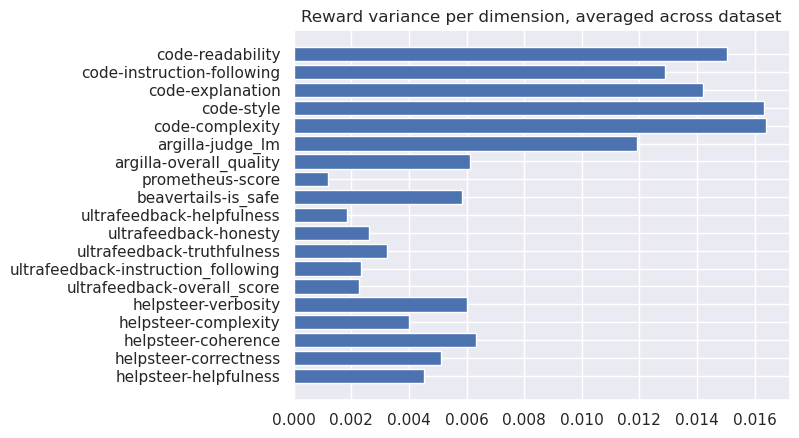

In [35]:
plt.barh(dimensional_attributes,
        mean_std_per_dimension)
plt.title("Reward variance per dimension, averaged across dataset")

Text(0.5, 1.0, 'Std. of reward variance per dimension, across dataset')

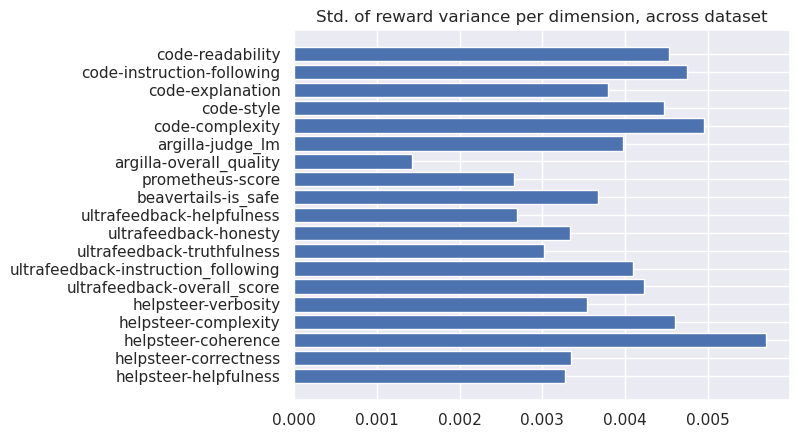

In [36]:
plt.barh(dimensional_attributes,
        std_of_std_per_dimension)
plt.title("Std. of reward variance per dimension, across dataset")

The clearest trends of the above:

The five code-related dimensions have the most variance across epistemic indices. This indicates that, for the average prompt, the code rewards have high uncertainty -- our epistemic nn has chosen to direct more randomness towards this dimension than the others. 

It's tempting to interpret this as the model's recognition that the coding dimensions should be uncertain on non coding questions. Perhaps this is the case. But recall - the model was never trained to take the coding rewards of anything outside of the coding dataset, so this would be a surprisingly advanced extrapolation for the model.

More likely the coding dimensions have high uncertainty even on coding prompts.

Text(0.5, 1.0, 'Mean reward value per dimension, with error indicating uncertainty')

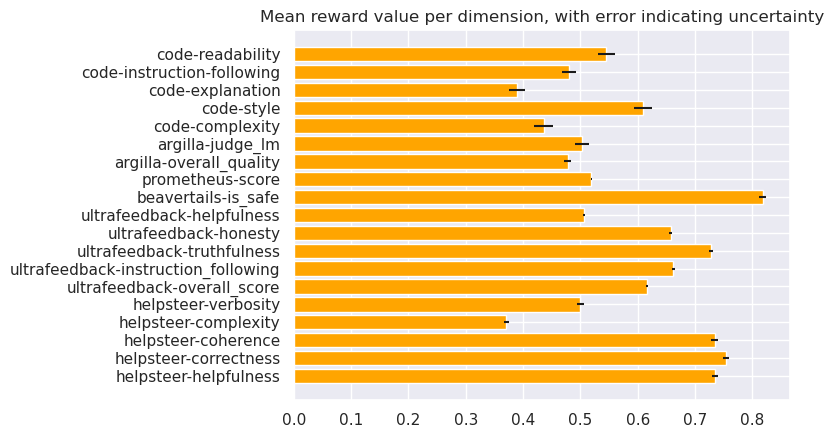

In [37]:
mean_reward_values = samples.mean(dim = 2).mean(dim = 0).detach().cpu().numpy()
plt.barh(dimensional_attributes, mean_reward_values, xerr = mean_std_per_dimension, color='orange')
plt.title("Mean reward value per dimension, with error indicating uncertainty")

But, in context, we can see that none of the uncertainty variances are very high compared to the actual values assumed by most dimensions, even thought the variance of those values across samples is considerable (below).

This suggests that the epistemic part of our reward model may have learned mainly to minimize itself -- or at least that examples on which there are really high epistemic variances are sufficiently out of distribution and sparse not to affect the std.

Text(0.5, 1.0, 'Mean reward value per dimension, with error indicating variance across samples')

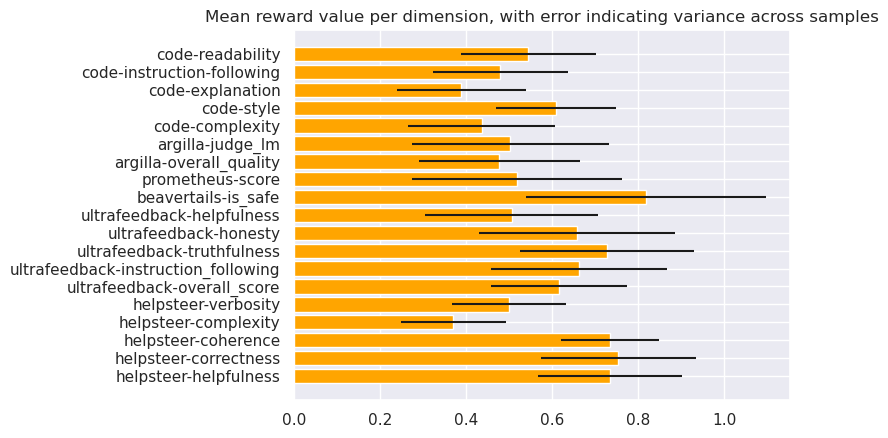

In [38]:
std_reward_values = samples.mean(dim = 2).std(dim = 0).detach().cpu().numpy()
plt.barh(dimensional_attributes, mean_reward_values, xerr = std_reward_values, color = 'orange')
plt.title("Mean reward value per dimension, with error indicating variance across samples")

### Histograms over uncertainty show no outliers

We'll start by examining one dimension: code-style. This seems like it should have examples that are ambiguous (is it style, or stupidity?)

In [39]:
samples = samples.detach().cpu()

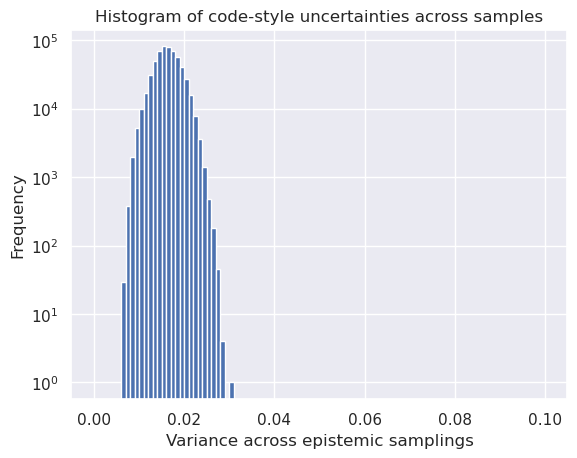

In [53]:
dim = 'code-style'
dist_uncertainties_code_style = samples.std(dim = 2)[:,dimensional_attributes.index(dim)]

plt.figure()
plt.hist(dist_uncertainties_code_style, bins = 100, range=[0,0.1])
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Variance across epistemic samplings")
plt.title(f"Histogram of {dim} uncertainties across samples")
plt.show()

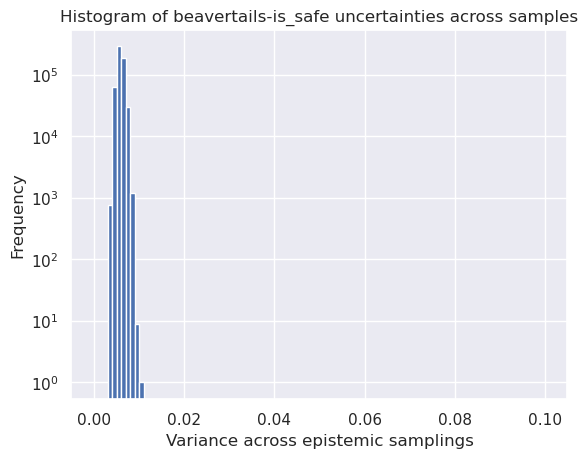

In [54]:
dim = 'beavertails-is_safe'
dist_uncertainties_code_style = samples.std(dim = 2)[:,dimensional_attributes.index(dim)]

plt.figure()
plt.hist(dist_uncertainties_code_style, bins = 100, range=[0,0.1])
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Variance across epistemic samplings")
plt.title(f"Histogram of {dim} uncertainties across samples")
plt.show()

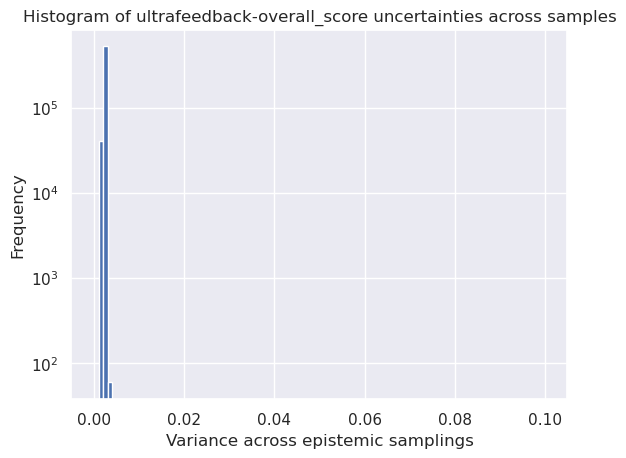

In [55]:
dim = 'ultrafeedback-overall_score'
dist_uncertainties_code_style = samples.std(dim = 2)[:,dimensional_attributes.index(dim)]

plt.figure()
plt.hist(dist_uncertainties_code_style, bins = 100, range=[0,0.1])
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Variance across epistemic samplings")
plt.title(f"Histogram of {dim} uncertainties across samples")
plt.show()

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dimension_histograms(matrix, dimension_names=None, title = "Uncertainty Histograms per Dimension", log_scale=False, **kwargs):
    """
    Given a matrix, produces a plot of histograms for each dimension on the same axis.
    
    Args:
    - matrix (np.ndarray): The input matrix (2D array) where each column represents a dimension.
    - dimension_names (list of str, optional): Names for each dimension to use in the legend.
    - log_scale (bool, optional): If True, use log scale for the y-axis.
    """
    # Check if the input is 2D
    if len(matrix.shape) != 2:
        raise ValueError("Input matrix must be 2-dimensional")
    
    num_dims = matrix.shape[1]
    
    # Use provided dimension names, or default to numbered dimensions
    if dimension_names is None:
        dimension_names = [f'Dimension {i + 1}' for i in range(num_dims)]
    elif len(dimension_names) != num_dims:
        raise ValueError("Length of dimension_names must match the number of dimensions in the matrix.")
    
    # Plot histograms for each dimension on the same axis
    plt.figure(figsize=(10, 6))
    for dim in range(num_dims):
        plt.hist(matrix[:, dim], bins=100, alpha=0.5, label=dimension_names[dim], **kwargs)
    
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.yscale('log' if log_scale else 'linear')
    plt.title(title)
    plt.legend()
    plt.show()

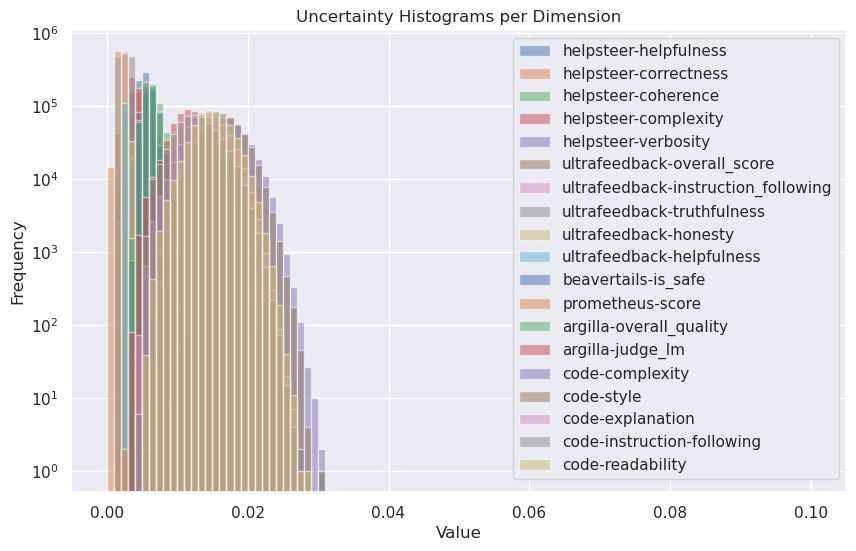

In [61]:
uncertainty_dists = samples.std(dim = 2)
plot_dimension_histograms(uncertainty_dists, dimension_names=dimensional_attributes, log_scale = True, range=[0,0.1])

*I apprehend* from this that there are _no_ samples with uncertainty variances higher than 0.04, which is a tenth of the value obtained by most rewards. Likely the epistemic portion of the network has learned nothing besides how to minimize itself.

Though it is curious that the uncertainty varies such across dimensions, and independently from the mean values of the dimensions. This suggests that it might be learning something...

# Second epinet

For our second epinet, we'll try to increase the amount of uncertainty by increasing the power of the learnable mlp. It'll have six layers instead of three. The regression thingie will stay the same.

In [67]:
from murdo.epinet_mlp import make_mlp_epinet
epinet, indexer = make_mlp_epinet(
    output_sizes = [hidden_size,n_attributes],
    epinet_hiddens = [hidden_size + n_attributes, 1024, 512, 256, 128, 64],
    index_dim = 8,
    prior_scale = 1,
    name = "second_epinet",
)

In [68]:
epinet

MLPEpinet(
  (base_mlp): ExposedMLP(
    (layers): ModuleList(
      (0): Linear(in_features=4096, out_features=19, bias=True)
    )
  )
  (train_epinet): ProjectedMLP(
    (mlp): Sequential(
      (0): Linear(in_features=4115, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=128, bias=True)
      (7): ReLU()
      (8): Linear(in_features=128, out_features=64, bias=True)
      (9): ReLU()
      (10): Linear(in_features=64, out_features=152, bias=True)
    )
  )
  (prior_epinet): ProjectedMLP(
    (mlp): Sequential(
      (0): Linear(in_features=4115, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(

In [69]:
# example usage
output = epinet(torch.randn(64, hidden_size), indexer(64))
train_predictions = output.train
prior_predictions = output.prior

In [70]:
train_predictions.shape

torch.Size([64, 19])

In [71]:
indexer(0)

tensor([ 1.1227,  3.1486, -2.2034, -0.6864, -0.4676,  0.6928, -0.1394,  0.4703])

For training, we'll follow the same principle as is the paper: simply masking the unknown dimensions when calculating losses. This is hopefully sufficiently in keeping with the nature of SGD. Future work might explore using uncertainty to more cleverly compensate for missing values.

In [74]:
#|export
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm, trange
import os
import glob
from datetime import datetime

def train_epinet(epinet, indexer, embeddings, sparse_rewards, hidden_size,
                 batch_size=64, num_epochs=100, lr=1e-3, load_latest=False):
    """
    Train the epinet using masked MSE loss.

    Args:
        epinet: The epinet MLP model
        indexer: The indexer function for epinet
        embeddings: Input embeddings tensor
        sparse_rewards: Sparse reward labels tensor
        hidden_size: Size of the hidden dimension
        batch_size: Batch size for training
        num_epochs: Number of training epochs
        lr: Learning rate
        load_latest: If True, load most recent saved model if it exists
    """
    # Setup save directory
    save_dir = os.path.join(os.path.expanduser("~"), "data", "ArmoRM", "weights", epinet.name)
    os.makedirs(save_dir, exist_ok=True)

    # Check for latest saved model if requested
    if load_latest:
        model_files = glob.glob(os.path.join(save_dir, "epinet_*.pt"))
        if model_files:
            latest_model = max(model_files, key=os.path.getctime)
            print(f"Loading latest model from {latest_model}")
            epinet.load_state_dict(torch.load(latest_model))
            return epinet

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epinet = epinet.to(device)

    # Setup optimizer
    optimizer = optim.Adam(epinet.parameters(), lr=lr)

    # Calculate number of batches
    n_samples = embeddings.shape[0]
    n_batches = n_samples // batch_size

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        # Shuffle data
        perm = torch.randperm(n_samples)
        embeddings = embeddings[perm]
        sparse_rewards = sparse_rewards[perm]

        # Batch training
        pbar = tqdm(range(n_batches), desc=f'Epoch {epoch+1}/{num_epochs}')
        for b in pbar:
            # Get batch and move to device
            start_idx = b * batch_size
            end_idx = start_idx + batch_size
            batch_embeddings = embeddings[start_idx:end_idx].to(device)
            batch_rewards = sparse_rewards[start_idx:end_idx].to(device)

            # Generate random indices for epinet
            indices = indexer(batch_size).to(device)

            # Forward pass
            epiout = epinet(batch_embeddings, indices)
            predicted_rewards = epiout.train + epiout.prior # preweighted sum of the learnable and fixed components

            # Create mask for non-nan values
            mask = ~torch.isnan(batch_rewards)

            # Calculate masked MSE loss
            loss = torch.mean((predicted_rewards[mask] - batch_rewards[mask])**2)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': epoch_loss/(b+1)})

            # Free memory
            del batch_embeddings
            del batch_rewards
            torch.cuda.empty_cache()

        # Print epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss/n_batches:.6f}')

        # Save model with timestamp
        if epoch % 25 == 0:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_path = os.path.join(save_dir, f"epinet_{timestamp}.pt")
            torch.save(epinet.state_dict(), save_path)
            print(f"Model saved to {save_path}")

    return epinet

Now we train! From above, Ridge regression without the epistemic nn achieved a loss of 0.022. Let's see if we can match that in the same order of magnitude, and perhaps even get below it.
Although as we've also changed the methodology (to gradient descent), and are adding randomness to the outputs, the raw numbers aren't directly comparable.

As seen below, we can quickly get in the same order of magnitude; the remainder of training is how to exploit randomness efficiently to further minimize the loss. It will be a good sanity check to see how much randomness is added: is the plain MLP doing most of the work, or are outputs of a substantial magnitude coming from the randomized portion of the network?

In [ ]:
trained_epinet = train_epinet(
    epinet=epinet,
    indexer=indexer,
    embeddings=embeddings,
    sparse_rewards=sparse_rewards,
    hidden_size=hidden_size,
    lr = 1e-5,
    load_latest = True,
)

Epoch 1/100: 100%|███████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 299.58it/s, loss=0.0486]


Epoch 1/100, Average Loss: 0.048610
Model saved to /home/piriac/data/ArmoRM/weights/second_epinet/epinet_20241112_113820.pt


Epoch 2/100: 100%|███████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 296.52it/s, loss=0.0321]


Epoch 2/100, Average Loss: 0.032116


Epoch 3/100: 100%|███████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 299.28it/s, loss=0.0304]


Epoch 3/100, Average Loss: 0.030358


Epoch 4/100: 100%|███████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 300.46it/s, loss=0.0294]


Epoch 4/100, Average Loss: 0.029386


Epoch 5/100: 100%|███████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 298.77it/s, loss=0.0287]


Epoch 5/100, Average Loss: 0.028737


Epoch 6/100: 100%|███████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 300.93it/s, loss=0.0283]


Epoch 6/100, Average Loss: 0.028288


Epoch 7/100: 100%|███████████████████████████████████████████████████████████| 8893/8893 [00:30<00:00, 294.13it/s, loss=0.0279]


Epoch 7/100, Average Loss: 0.027935


Epoch 8/100: 100%|███████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 302.97it/s, loss=0.0276]


Epoch 8/100, Average Loss: 0.027635


Epoch 9/100: 100%|███████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 299.33it/s, loss=0.0274]


Epoch 9/100, Average Loss: 0.027413


Epoch 10/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 298.71it/s, loss=0.0272]


Epoch 10/100, Average Loss: 0.027183


Epoch 11/100: 100%|███████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 298.17it/s, loss=0.027]


Epoch 11/100, Average Loss: 0.027015


Epoch 12/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:30<00:00, 291.76it/s, loss=0.0269]


Epoch 12/100, Average Loss: 0.026851


Epoch 13/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 299.45it/s, loss=0.0267]


Epoch 13/100, Average Loss: 0.026721


Epoch 14/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 298.83it/s, loss=0.0266]


Epoch 14/100, Average Loss: 0.026571


Epoch 15/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 299.46it/s, loss=0.0265]


Epoch 15/100, Average Loss: 0.026482


Epoch 29/100:  90%|███████████████████████████████████████████████████▉      | 7963/8893 [00:26<00:03, 295.14it/s, loss=0.0255]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 33/100:  38%|█████████████████████▉                                    | 3370/8893 [00:11<00:18, 296.51it/s, loss=0.0253]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 33/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:30<00:00, 296.36i

Epoch 33/100, Average Loss: 0.025336


Epoch 36/100:  80%|██████████████████████████████████████████████▌           | 7142/8893 [00:24<00:05, 298.03it/s, loss=0.0253]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 39/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:30<00:00, 291.68it/s, loss=0.0252]


Epoch 39/100, Average Loss: 0.025152


Epoch 40/100:  29%|████████████████▊                                         | 2581/8893 [00:08<00:20, 308.61it/s, loss=0.0252]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 43/100:  79%|██████████████████████████████████████████████▌            | 7014/8893 [00:23<00:06, 295.46it/s, loss=0.025]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 43/100: 100%|███████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 297.21

Epoch 43/100, Average Loss: 0.025021


Epoch 46/100: 100%|███████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 297.23it/s, loss=0.025]


Epoch 46/100, Average Loss: 0.024975


Epoch 47/100:  12%|███████▏                                                  | 1102/8893 [00:03<00:25, 299.88it/s, loss=0.0248]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 50/100:  84%|████████████████████████████████████████████████▌         | 7453/8893 [00:24<00:04, 307.77it/s, loss=0.0249]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 53/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 299.37i

Epoch 53/100, Average Loss: 0.024824


Epoch 54/100:  32%|██████████████████▋                                       | 2874/8893 [00:09<00:20, 297.98it/s, loss=0.0249]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 57/100:  72%|█████████████████████████████████████████▉                | 6427/8893 [00:22<00:07, 311.37it/s, loss=0.0247]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 57/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:31<00:00, 281.73i

Epoch 57/100, Average Loss: 0.024721


Epoch 60/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 297.79it/s, loss=0.0247]


Epoch 60/100, Average Loss: 0.024676


Epoch 61/100:  19%|███████████▎                                              | 1728/8893 [00:05<00:24, 295.70it/s, loss=0.0248]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 61/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 297.25it/s, loss=0.0247]


Epoch 61/100, Average Loss: 0.024650


Epoch 64/100:  87%|██████████████████████████████████████████████████▍       | 7738/8893 [00:26<00:03, 292.60it/s, loss=0.0246]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 65/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:30<00:00, 294.91it/s, loss=0.0246]


Epoch 65/100, Average Loss: 0.024611


Epoch 68/100:  81%|███████████████████████████████████████████████▏          | 7240/8893 [00:24<00:05, 295.65it/s, loss=0.0245]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 71/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 298.33it/s, loss=0.0245]


Epoch 71/100, Average Loss: 0.024532


Epoch 74/100: 100%|██████████████████████████████████████████████████████████| 8893/8893 [00:29<00:00, 301.31it/s, loss=0.0245]


Epoch 74/100, Average Loss: 0.024509


Epoch 75/100:   3%|█▋                                                         | 250/8893 [00:00<00:28, 303.83it/s, loss=0.0244]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 78/100:  90%|████████████████████████████████████████████████████▎     | 8013/8893 [00:26<00:02, 298.62it/s, loss=0.0245]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 82/100:  43%|████████████████████████▉                                 | 3827/8893 [00:12<00:16, 299.28i

Epoch 98/100, Average Loss: 0.024246


Epoch 99/100:   1%|▍                                                           | 60/8893 [00:00<00:29, 298.54it/s, loss=0.0244]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 99/100:  65%|█████████████████████████████████████▋                    | 5776/8893 [00:19<00:10, 299.05it/s, loss=0.0242]

In [98]:
trained_epinet

MLPEpinet(
  (base_mlp): ExposedMLP(
    (layers): ModuleList(
      (0): Linear(in_features=4096, out_features=19, bias=True)
    )
  )
  (train_epinet): ProjectedMLP(
    (mlp): Sequential(
      (0): Linear(in_features=4115, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=128, bias=True)
      (7): ReLU()
      (8): Linear(in_features=128, out_features=64, bias=True)
      (9): ReLU()
      (10): Linear(in_features=64, out_features=152, bias=True)
    )
  )
  (prior_epinet): ProjectedMLP(
    (mlp): Sequential(
      (0): Linear(in_features=4115, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(

## Analysis

The first thing we need in evaluating our epinet is a quantification of uncertainty per dimension. We can then perform this measurement across the dataset, and report:
1. Average uncertainty per dimension across all samples
2. Variance of uncertainty per dimension across all samples

In [99]:
def sample_epinet_outputs(trained_epinet, indexer, embeddings, n_samples=10, batch_size=128):
    """
    Sample multiple outputs from a trained epinet for each input embedding.

    Args:
        trained_epinet: The trained epinet model
        indexer: The indexer function for generating random indices
        embeddings: Input embeddings tensor of shape (n_embeddings, hidden_size)
        n_samples: Number of samples to generate per input
        batch_size: Batch size for processing

    Returns:
        torch.Tensor: Array of shape (n_embeddings, n_dimensions, n_samples)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trained_epinet = trained_epinet.to(device)

    n_embeddings = embeddings.shape[0]
    n_dimensions = 19  # number of reward dimensions

    # Initialize output tensor
    all_outputs = torch.zeros((n_embeddings, n_dimensions, n_samples), device=device)
    # Process in batches
    with torch.no_grad():  # disable gradient computation for inference
        for batch_start in tqdm(range(0, n_embeddings, batch_size), desc="Processing batches"):
            # Get batch of embeddings
            batch_end = min(batch_start + batch_size, n_embeddings)
            batch_embeddings = embeddings[batch_start:batch_end].to(device)

            # Initialize batch predictions tensor
            batch_predictions = torch.zeros((batch_end - batch_start, n_dimensions, n_samples), device=device)

            # Sample multiple times for each embedding
            for i in range(n_samples):
                # Generate index for this sample
                indices = indexer(1).to(device)

                # Get predictions for this sample
                outputs = trained_epinet(batch_embeddings, indices)
                predictions = outputs.train + outputs.prior  # combine train and prior predictions

                # Store predictions for this sample
                batch_predictions[:, :, i] = predictions

            # Store in output tensor
            all_outputs[batch_start:batch_end] = batch_predictions
            # Clear GPU memory
            del batch_embeddings, indices, outputs, predictions, batch_predictions
            torch.cuda.empty_cache()

    return all_outputs



In [100]:
torch.vstack([indexer(42) for i in range(10)])

tensor([[-1.3468e+00,  4.9318e-01, -1.2014e+00, -2.0841e-02, -5.7890e-01,
         -2.2862e+00, -4.4042e-01, -1.2923e+00],
        [-3.8870e+00, -8.2493e-01, -4.4450e-02, -7.9117e-01, -9.4554e-01,
         -1.2334e+00, -2.9274e-01,  1.2098e+00],
        [ 1.0315e+00,  1.7036e+00, -2.7062e-01, -9.4882e-01,  1.6954e+00,
          1.1732e-02, -1.2950e+00, -4.1846e-01],
        [ 2.2938e-03,  2.1590e-01,  1.3824e+00,  2.1640e-01,  5.7901e-01,
         -1.0551e+00,  9.9827e-01, -4.2259e-02],
        [ 7.8955e-01,  4.7119e-01, -2.4523e-01,  7.2177e-01, -6.3887e-01,
          1.5450e+00,  6.6923e-01,  1.1624e-01],
        [-7.4187e-01,  2.2359e-01, -4.3670e-02, -1.9423e+00, -1.1002e+00,
          4.4600e-01, -8.2254e-02, -2.5949e-01],
        [-6.9741e-02, -2.2407e+00, -3.3525e-02,  1.0415e+00, -1.2322e-02,
         -1.4905e+00, -7.8149e-01,  6.2612e-02],
        [ 1.8464e+00, -8.3442e-01,  5.1781e-01, -6.1389e-01,  7.0147e-01,
         -4.1391e-01, -6.3437e-01,  1.5307e-01],
        [-2.7835

In [101]:
indexer(42)

tensor([-1.6049,  0.5306,  1.9399, -0.4514, -1.6781,  0.1443,  1.7636,  1.1809])

In [102]:
# Usage example:
samples = sample_epinet_outputs(
    trained_epinet=trained_epinet,
    indexer=indexer,
    embeddings=embeddings,
    n_samples=100,
    batch_size=128
)

# Calculate statistics
mean_predictions = samples.mean(dim=2)  # Average across samples
std_predictions = samples.std(dim=2)    # Standard deviation across samples

Processing batches: 100%|██████████████████████████████████████████████████████████████████| 4447/4447 [03:40<00:00, 20.16it/s]


In [103]:
samples.shape

torch.Size([569185, 19, 100])

In [104]:
samples[0,0,:]

tensor([0.7379, 0.7435, 0.7402, 0.7305, 0.7479, 0.7304, 0.7381, 0.7402, 0.7355,
        0.7335, 0.7534, 0.7424, 0.7423, 0.7374, 0.7361, 0.7342, 0.7452, 0.7435,
        0.7379, 0.7438, 0.7439, 0.7263, 0.7329, 0.7431, 0.7429, 0.7368, 0.7416,
        0.7487, 0.7292, 0.7531, 0.7369, 0.7369, 0.7457, 0.7306, 0.7526, 0.7315,
        0.7324, 0.7475, 0.7360, 0.7402, 0.7401, 0.7406, 0.7337, 0.7320, 0.7369,
        0.7359, 0.7317, 0.7412, 0.7385, 0.7466, 0.7317, 0.7409, 0.7358, 0.7397,
        0.7340, 0.7491, 0.7319, 0.7329, 0.7358, 0.7427, 0.7304, 0.7403, 0.7463,
        0.7224, 0.7291, 0.7384, 0.7217, 0.7370, 0.7293, 0.7379, 0.7370, 0.7483,
        0.7451, 0.7192, 0.7506, 0.7305, 0.7342, 0.7312, 0.7592, 0.7412, 0.7407,
        0.7400, 0.7255, 0.7392, 0.7327, 0.7358, 0.7375, 0.7460, 0.7332, 0.7269,
        0.7324, 0.7435, 0.7515, 0.7351, 0.7341, 0.7433, 0.7283, 0.7443, 0.7280,
        0.7440], device='cuda:0')

In [109]:
samples.std(dim=2)

tensor([[0.0074, 0.0074, 0.0066,  ..., 0.0046, 0.0089, 0.0057],
        [0.0074, 0.0074, 0.0066,  ..., 0.0046, 0.0089, 0.0057],
        [0.0072, 0.0074, 0.0070,  ..., 0.0046, 0.0092, 0.0059],
        ...,
        [0.0067, 0.0069, 0.0064,  ..., 0.0042, 0.0083, 0.0068],
        [0.0067, 0.0066, 0.0067,  ..., 0.0044, 0.0083, 0.0070],
        [0.0067, 0.0067, 0.0066,  ..., 0.0043, 0.0082, 0.0069]],
       device='cuda:0')

This is the 'uncertainty' per dimension, averaged across all samples:

In [110]:
mean_std_per_dimension = (samples.std(dim=2)).mean(dim=0)  # Average across samples
mean_std_per_dimension

tensor([0.0075, 0.0072, 0.0068, 0.0051, 0.0034, 0.0033, 0.0039, 0.0034, 0.0040,
        0.0041, 0.0044, 0.0043, 0.0050, 0.0087, 0.0085, 0.0100, 0.0043, 0.0091,
        0.0067], device='cuda:0')

The variance of uncertainty per dimension, across all samples:

In [111]:
std_of_std_per_dimension = (samples.std(dim=2)).std(dim=0)  # Average across samples
std_of_std_per_dimension

tensor([0.0005, 0.0005, 0.0006, 0.0005, 0.0003, 0.0004, 0.0003, 0.0003, 0.0004,
        0.0004, 0.0003, 0.0003, 0.0004, 0.0006, 0.0007, 0.0007, 0.0003, 0.0007,
        0.0005], device='cuda:0')

These early results show that 
1. different reward dimensions have different 'uncertainties'.
2. The uncertainty per reward dimension changes across samples on a magnitude equal to the original std.
3. The last six dimensions are, weirdly, far more uncertain than the first 13. 

In [112]:
mean_std_per_dimension = mean_std_per_dimension.detach().cpu().numpy()
std_of_std_per_dimension = std_of_std_per_dimension.detach().cpu().numpy()

## Most uncertain dimensions?

In [113]:
# Define attributes (reward objectives)
dimensional_attributes = [
    "helpsteer-helpfulness",
    "helpsteer-correctness",
    "helpsteer-coherence",
    "helpsteer-complexity",
    "helpsteer-verbosity",
    "ultrafeedback-overall_score",
    "ultrafeedback-instruction_following",
    "ultrafeedback-truthfulness",
    "ultrafeedback-honesty",
    "ultrafeedback-helpfulness",
    "beavertails-is_safe",
    "prometheus-score",
    "argilla-overall_quality",
    "argilla-judge_lm",
    "code-complexity",
    "code-style",
    "code-explanation",
    "code-instruction-following",
    "code-readability",
]

Text(0.5, 1.0, 'Reward variance per dimension, averaged across dataset')

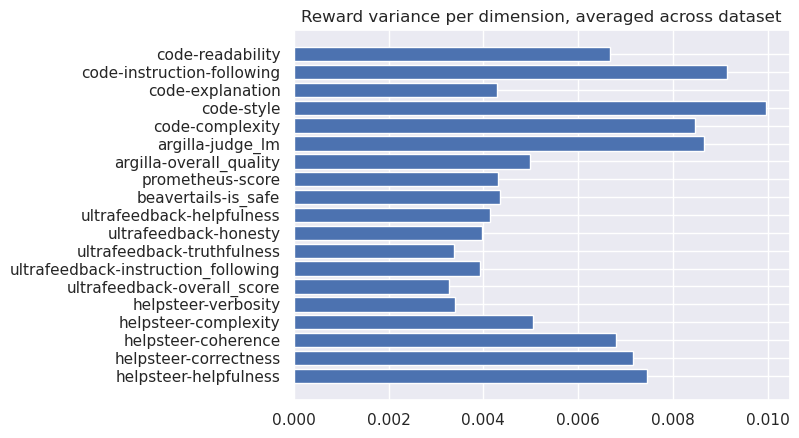

In [114]:
plt.barh(dimensional_attributes,
        mean_std_per_dimension)
plt.title("Reward variance per dimension, averaged across dataset")

Curiously, in this training run, the code-explanation dimension is much less variable than before; the other code dimensions remain pretty variable.

Text(0.5, 1.0, 'Std. of reward variance per dimension, across dataset')

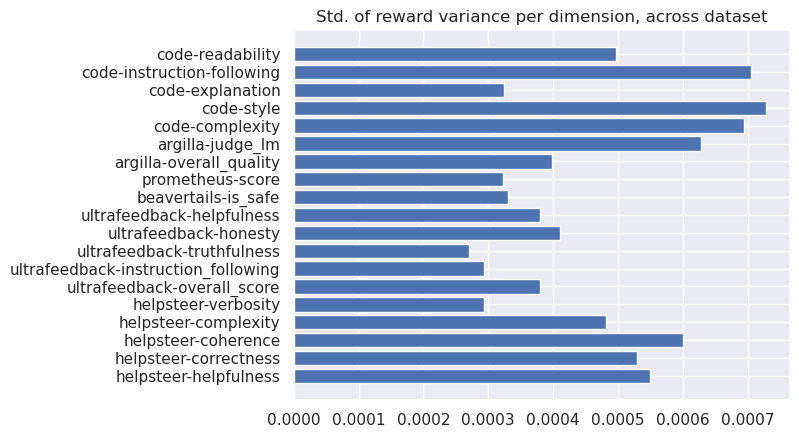

In [115]:
plt.barh(dimensional_attributes,
        std_of_std_per_dimension)
plt.title("Std. of reward variance per dimension, across dataset")

Text(0.5, 1.0, 'Mean reward value per dimension, with error indicating uncertainty')

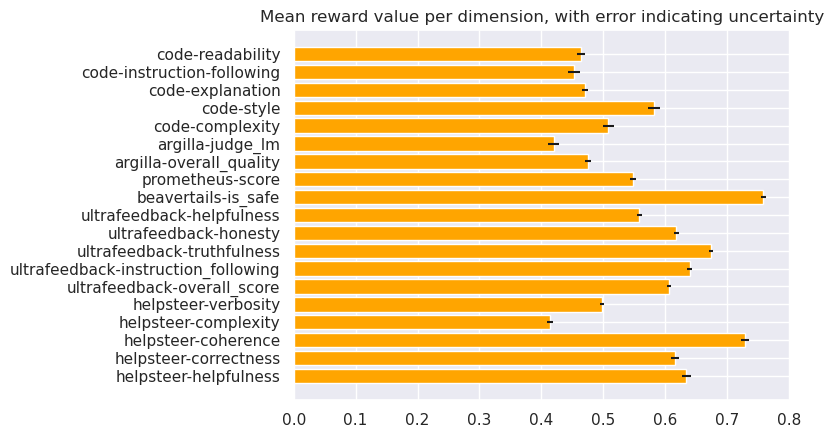

In [116]:
mean_reward_values = samples.mean(dim = 2).mean(dim = 0).detach().cpu().numpy()
plt.barh(dimensional_attributes, mean_reward_values, xerr = mean_std_per_dimension, color='orange')
plt.title("Mean reward value per dimension, with error indicating uncertainty")

So even with the more powerful epinet, the variance in reward values remains a miniscule part of the total. 

Text(0.5, 1.0, 'Mean reward value per dimension, with error indicating variance across samples')

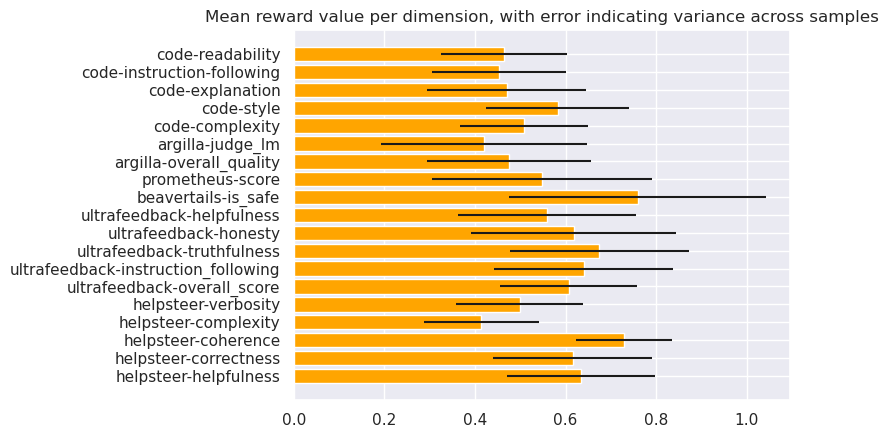

In [117]:
std_reward_values = samples.mean(dim = 2).std(dim = 0).detach().cpu().numpy()
plt.barh(dimensional_attributes, mean_reward_values, xerr = std_reward_values, color = 'orange')
plt.title("Mean reward value per dimension, with error indicating variance across samples")

### Histograms over uncertainty show no outliers

We'll start by examining one dimension: code-style. This seems like it should have examples that are ambiguous (is it style, or stupidity?)

In [118]:
samples = samples.detach().cpu()

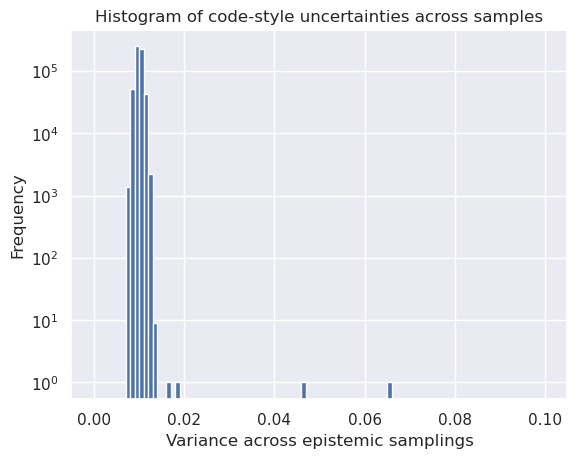

In [119]:
dim = 'code-style'
dist_uncertainties_code_style = samples.std(dim = 2)[:,dimensional_attributes.index(dim)]

plt.figure()
plt.hist(dist_uncertainties_code_style, bins = 100, range=[0,0.1])
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Variance across epistemic samplings")
plt.title(f"Histogram of {dim} uncertainties across samples")
plt.show()

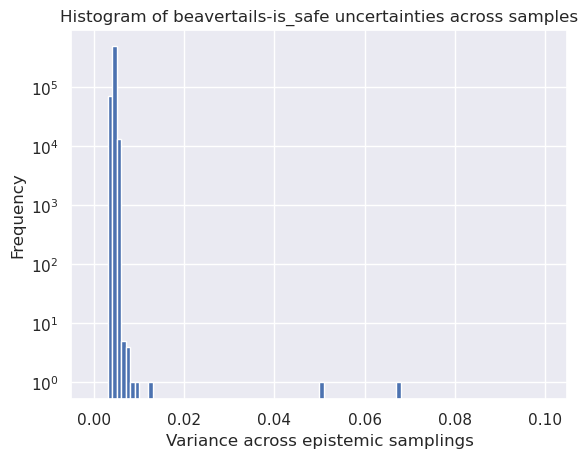

In [120]:
dim = 'beavertails-is_safe'
dist_uncertainties_code_style = samples.std(dim = 2)[:,dimensional_attributes.index(dim)]

plt.figure()
plt.hist(dist_uncertainties_code_style, bins = 100, range=[0,0.1])
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Variance across epistemic samplings")
plt.title(f"Histogram of {dim} uncertainties across samples")
plt.show()

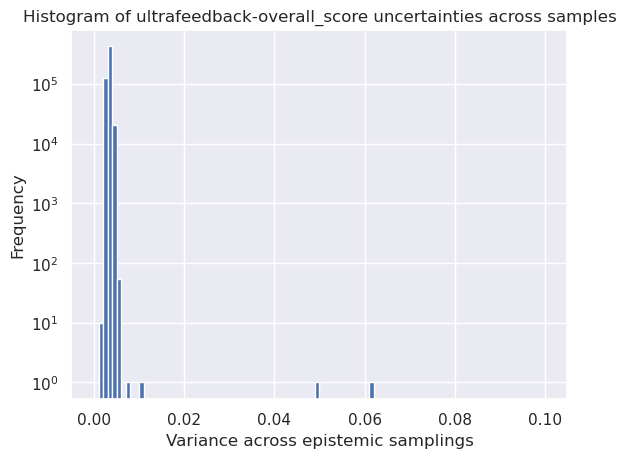

In [121]:
dim = 'ultrafeedback-overall_score'
dist_uncertainties_code_style = samples.std(dim = 2)[:,dimensional_attributes.index(dim)]

plt.figure()
plt.hist(dist_uncertainties_code_style, bins = 100, range=[0,0.1])
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Variance across epistemic samplings")
plt.title(f"Histogram of {dim} uncertainties across samples")
plt.show()

In [122]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dimension_histograms(matrix, dimension_names=None, title = "Uncertainty Histograms per Dimension", log_scale=False, **kwargs):
    """
    Given a matrix, produces a plot of histograms for each dimension on the same axis.
    
    Args:
    - matrix (np.ndarray): The input matrix (2D array) where each column represents a dimension.
    - dimension_names (list of str, optional): Names for each dimension to use in the legend.
    - log_scale (bool, optional): If True, use log scale for the y-axis.
    """
    # Check if the input is 2D
    if len(matrix.shape) != 2:
        raise ValueError("Input matrix must be 2-dimensional")
    
    num_dims = matrix.shape[1]
    
    # Use provided dimension names, or default to numbered dimensions
    if dimension_names is None:
        dimension_names = [f'Dimension {i + 1}' for i in range(num_dims)]
    elif len(dimension_names) != num_dims:
        raise ValueError("Length of dimension_names must match the number of dimensions in the matrix.")
    
    # Plot histograms for each dimension on the same axis
    plt.figure(figsize=(10, 6))
    for dim in range(num_dims):
        plt.hist(matrix[:, dim], bins=100, alpha=0.5, label=dimension_names[dim], **kwargs)
    
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.yscale('log' if log_scale else 'linear')
    plt.title(title)
    plt.legend()
    plt.show()

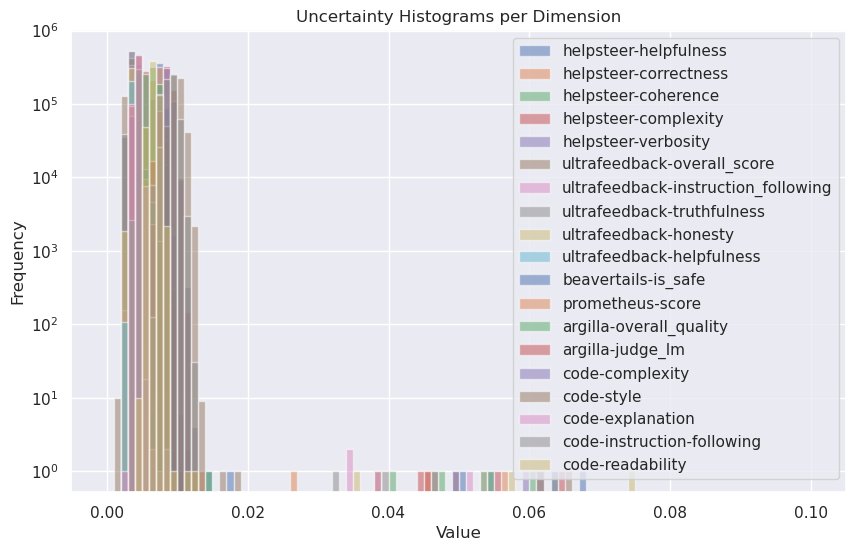

In [123]:
uncertainty_dists = samples.std(dim = 2)
plot_dimension_histograms(uncertainty_dists, dimension_names=dimensional_attributes, log_scale = True, range=[0,0.1])

Aha! This histogram shows the clearest change: with a more poweful MLP, there are smatterings of inputs with much higher uncertainties. But the highest are still 1/10 of the actual reward values.

## Deeper Evaluations

What does this really mean? Has adding uncertainty helped or hurt our reward model? 

We can only fully evaluate this once the second piece of the puzzle -- the gating network -- has been trained, which introduces another confounding set of design decisions. But perhaps some rougher comparisons can give us an initial sense of success:

Here are some questions we can consider:

1. Does the epistemic reward model have a lower error predicting reward values, when uncertainty is factored in?
2. In a comparative analysis across datasets, do we find that reward dimensions have higher uncertainty on a dataset of questions which should be unrelated to the reward?
3. How much do the reward predictions of our epistemic RM differ from the regular RM? (To rigorously answer this, we should also train an linear regression layer with backprop instead of sklearn's ridge regression, to see if that accounts for the majority of the difference.)

# Conclusion